In [ ]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/00NLP/spam.csv", encoding="latin-1")
data = data.dropna(how="any", axis=1)

# Rename names columns
data.columns = ['label', 'messages']
data.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##EDA (Exploratory Data Analysis)


In [ ]:
#check null
data.isna().sum()

label       0
messages    0
dtype: int64

In [ ]:
data.describe()

,label,messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
data.groupby('label').describe()

messages                                                               
         count unique                                                top freq
label                                                                        
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

In [ ]:
# Get all the ham and spam emails
ham_msg = data[data.label =='ham']
spam_msg = data[data.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.messages.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.messages.to_numpy().tolist())

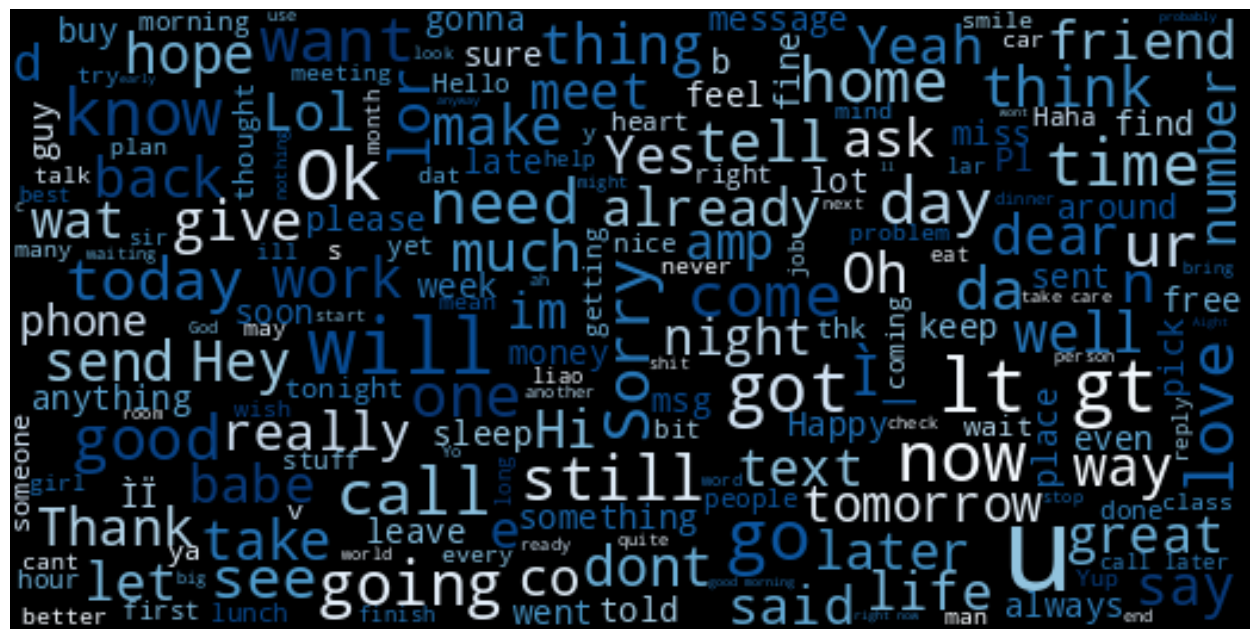

In [ ]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

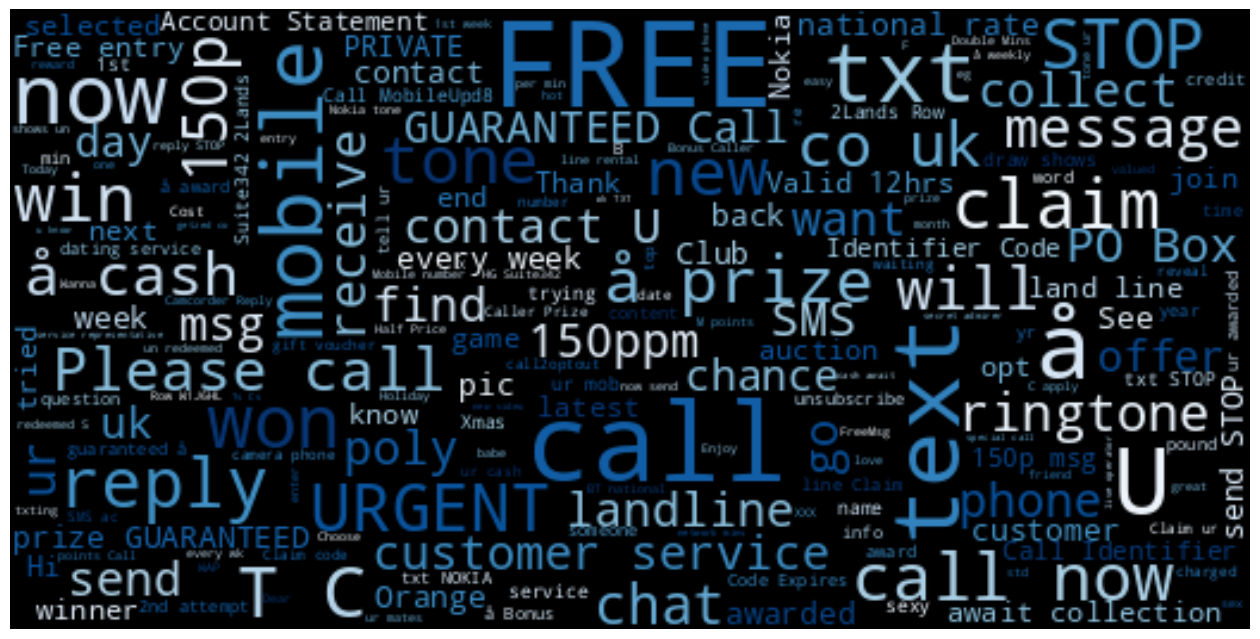

In [ ]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

##Data Cleaning

In [ ]:
# Remove duplicates
print("Data before remove duplicates: \n")
print(data.describe())
data = data.drop_duplicates()

print("\n\nData after remove duplicates: \n")
print(data.describe())

Data before remove duplicates: 

       label                messages
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30


Data after remove duplicates: 

       label                                           messages
count   5169                                               5169
unique     2                                               5169
top      ham  Go until jurong point, crazy.. Available only ...
freq    4516                                                  1


In [ ]:
#Downsampling
ham_msg_data = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_data = spam_msg
msg_data = ham_msg_data.append(spam_msg_data).reset_index(drop=True)
msg_data.groupby('label').describe()

<ipython-input-17-406f42e517fb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_data = ham_msg_data.append(spam_msg_data).reset_index(drop=True)


messages                                                               
         count unique                                                top freq
label                                                                        
ham        747    737                                              Ok...    3
spam       747    653  Please call our customer service representativ...    4

##Data Preprocessing

In [ ]:
#Converting label into numerical values
msg_data['label_num'] = msg_data.label.map({'ham':0, 'spam':1})
msg_data.head()

,label,messages,label_num
0,ham,"Yes, princess. Toledo.",0
1,ham,Dude while were makin those weirdy brownies my...,0
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",0
3,ham,Then u ask darren go n pick u lor... But i oso...,0
4,ham,Lol no. I just need to cash in my nitros. Hurr...,0


In [ ]:
#Feature Engineering
msg_data['msg_len'] = msg_data.messages.apply(len)
msg_data.head()

,label,messages,label_num,msg_len
0,ham,"Yes, princess. Toledo.",0,22
1,ham,Dude while were makin those weirdy brownies my...,0,88
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",0,169
3,ham,Then u ask darren go n pick u lor... But i oso...,0,74
4,ham,Lol no. I just need to cash in my nitros. Hurr...,0,75


Text(0.5, 0, 'Message Length')

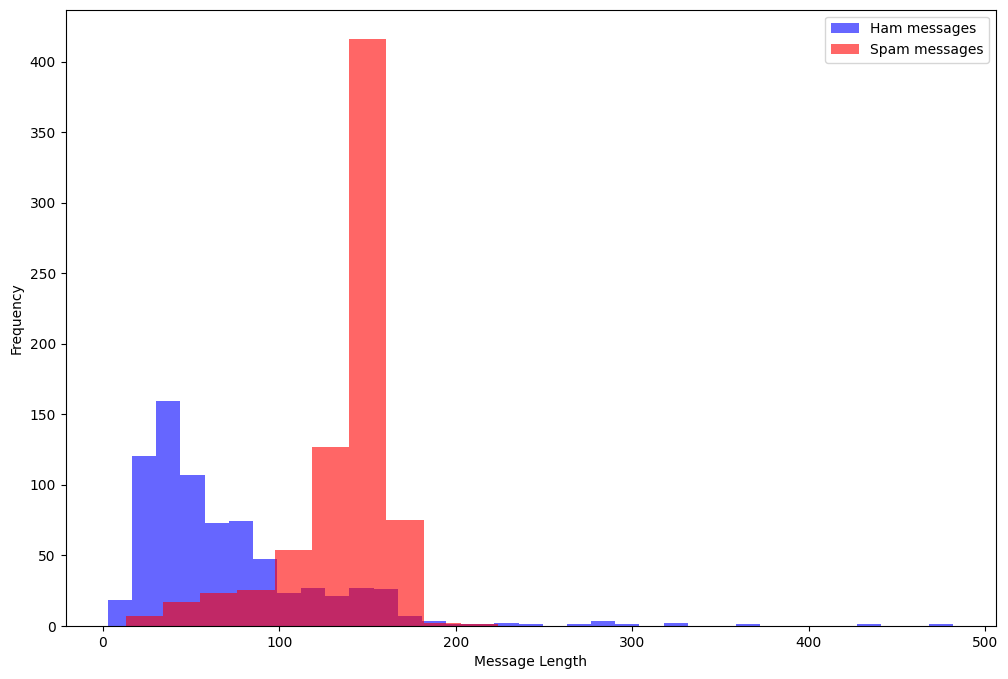

In [ ]:
plt.figure(figsize=(12,8))
msg_data[msg_data.label=='ham'].msg_len.plot(bins=35, kind='hist', color='blue',
                                       label='Ham messages', alpha=0.6)
msg_data[msg_data.label=='spam'].msg_len.plot(kind='hist', color='red',
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [ ]:
msg_data[msg_data.label=='spam'].describe()


,label_num,msg_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


In [ ]:
msg_data[msg_data.label=='ham'].describe()


,label_num,msg_len
count,747.0,747.000000
mean,0.0,69.626506
std,0.0,52.881384
min,0.0,3.000000
25%,0.0,34.000000
50%,0.0,52.000000
75%,0.0,88.000000
max,0.0,482.000000


In [ ]:
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords

def process_text(text):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

msg_data['cleaned_msg'] = msg_data.messages.apply(process_text)
msg_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,messages,label_num,msg_len,cleaned_msg
0,ham,"Yes, princess. Toledo.",0,22,Yes princess Toledo
1,ham,Dude while were makin those weirdy brownies my...,0,88,Dude makin weirdy brownies sister made awesome...
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",0,169,Hiya sorry didnt hav signal havent seen heard ...
3,ham,Then u ask darren go n pick u lor... But i oso...,0,74,ask darren go n pick lor oso sian tmr haf meet...
4,ham,Lol no. I just need to cash in my nitros. Hurr...,0,75,Lol need cash nitros Hurry come crash


In [ ]:
# # Map ham label as 0 and spam as 1
# msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
# msg_label = msg_df['msg_type'].values

# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_data['cleaned_msg'], msg_data['label_num'], test_size=0.2, random_state=15)

#Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(train_msg)

# learn training data vocabulary, then use it to create a document-term matrix
train_msg_dtm = vect.transform(train_msg)

# equivalently: combine fit and transform into a single step
train_msg_dtm = vect.fit_transform(train_msg)

# examine the document-term matrix
print(type(train_msg_dtm), train_msg_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
test_msg_dtm = vect.transform(test_msg)
print(type(test_msg_dtm), test_msg_dtm.shape)


<class 'scipy.sparse._csr.csr_matrix'> (1195, 4068)
<class 'scipy.sparse._csr.csr_matrix'> (299, 4068)


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(train_msg_dtm)
tfidf_transformer.transform(train_msg_dtm)

<1195x4068 sparse matrix of type '<class 'numpy.float64'>'
	with 13347 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
%time nb.fit(train_msg_dtm, train_labels)

CPU times: user 3.39 ms, sys: 0 ns, total: 3.39 ms
Wall time: 3.6 ms


MultinomialNB()

In [ ]:
from sklearn import metrics

# predictions for X_test_dtm
y_pred = nb.predict(test_msg_dtm)

print("The test accuracy score of Mutinomial NB is ", metrics.accuracy_score(test_labels, y_pred))
print("The test f1 score of Mutinomial NB is ", metrics.f1_score(test_labels, y_pred))
print("The test precision of Mutinomial NB is ", metrics.precision_score(test_labels, y_pred))
print("The test recall of Mutinomial NB is ", metrics.recall_score(test_labels, y_pred))



The test accuracy score of Mutinomial NB is  0.959866220735786
The test f1 score of Mutinomial NB is  0.9610389610389611
The test precision of Mutinomial NB is  0.9487179487179487
The test recall of Mutinomial NB is  0.9736842105263158


#Dense Spam Detection Model



##Tokenization

In [ ]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
"""
num_words = how many unique words
oov_token = When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls
char_level = If it is “True” then every character will be treated as a token. We set it as “False”, hence every word will be treated as a token.
"""
tokenizer.fit_on_texts(train_msg)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'call': 2,
 'free': 3,
 'txt': 4,
 'get': 5,
 'claim': 6,
 'text': 7,
 'stop': 8,
 'mobile': 9,
 'reply': 10,
 'prize': 11,
 'send': 12,
 'new': 13,
 'go': 14,
 'please': 15,
 'urgent': 16,
 'cash': 17,
 'win': 18,
 'know': 19,
 'nokia': 20,
 'phone': 21,
 'contact': 22,
 'want': 23,
 'week': 24,
 'service': 25,
 'good': 26,
 'guaranteed': 27,
 '16': 28,
 'love': 29,
 '18': 30,
 'hi': 31,
 'got': 32,
 'time': 33,
 'customer': 34,
 'ltgt': 35,
 'chat': 36,
 'per': 37,
 'ok': 38,
 'one': 39,
 'tone': 40,
 'day': 41,
 'like': 42,
 'see': 43,
 'back': 44,
 'line': 45,
 'holiday': 46,
 'come': 47,
 'number': 48,
 '1': 49,
 'draw': 50,
 '150ppm': 51,
 'r': 52,
 'shows': 53,
 'landline': 54,
 'å£1000': 55,
 'awarded': 56,
 'apply': 57,
 'tcs': 58,
 'latest': 59,
 'live': 60,
 'msg': 61,
 'c': 62,
 'å£2000': 63,
 'box': 64,
 'sorry': 65,
 'mins': 66,
 'dear': 67,
 'message': 68,
 'camera': 69,
 'ill': 70,
 '3': 71,
 'code': 72,
 'video': 73,
 'find': 74,
 'take': 75,
 'tell': 76,

In [ ]:
# check how many words
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4116 unique tokens in training data. 


##Sequencing and Padding

In [ ]:
# Sequencing and padding on training and testing
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

# """
#     padding = ‘pre’ or ‘post (default pre). By using pre, we pad before each sequence and by using post we pad after each sequence.
#     maxlen = maximum length of all sequences. Here max_len=50 hence, we are only going to use 50 words in a sentence. If not provided, by default it will use the maximum length of the longest sentence.
#     truncating = ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will truncate at the end of the sequences.
# """

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(18, 4)

In [ ]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

##Buiding Model

In [ ]:
#hyperparameters
vocab_size = 500
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [ ]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])


In [ ]:
# fitting a dense spam detector model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/50
38/38 - 1s - loss: 0.6899 - accuracy: 0.5088 - val_loss: 0.6860 - val_accuracy: 0.5084 - 1s/epoch - 34ms/step
Epoch 2/50
38/38 - 0s - loss: 0.6796 - accuracy: 0.6100 - val_loss: 0.6714 - val_accuracy: 0.7090 - 111ms/epoch - 3ms/step
Epoch 3/50
38/38 - 0s - loss: 0.6578 - accuracy: 0.7523 - val_loss: 0.6402 - val_accuracy: 0.7926 - 105ms/epoch - 3ms/step
Epoch 4/50
38/38 - 0s - loss: 0.6147 - accuracy: 0.8377 - val_loss: 0.5833 - val_accuracy: 0.8662 - 114ms/epoch - 3ms/step
Epoch 5/50
38/38 - 0s - loss: 0.5473 - accuracy: 0.8669 - val_loss: 0.5068 - val_accuracy: 0.8829 - 120ms/epoch - 3ms/step
Epoch 6/50
38/38 - 0s - loss: 0.4720 - accuracy: 0.8745 - val_loss: 0.4317 - val_accuracy: 0.8796 - 118ms/epoch - 3ms/step
Epoch 7/50
38/38 - 0s - loss: 0.4002 - accuracy: 0.8895 - val_loss: 0.3643 - val_accuracy: 0.8963 - 107ms/epoch - 3ms/step
Epoch 8/50
38/38 - 0s - loss: 0.3355 - accuracy: 0.9021 - val_loss: 0.3127 - val_accuracy: 0.9097 - 104ms/epoch - 3ms/step
Epoch 9/50
38/38 -

In [ ]:
# Model performance on test data
# model.evaluate(testing_padded, test_labels)
results = model.evaluate(testing_padded, test_labels)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

10/10 [==============================] - 0s 3ms/step - loss: 0.1156 - accuracy: 0.9632
    Test Loss: 0.11563
Test Accuracy: 96.32%


In [ ]:
# visualize
# Read as a dataframe
plotting = pd.DataFrame(history.history)
# Rename column
plotting.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    plotting[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

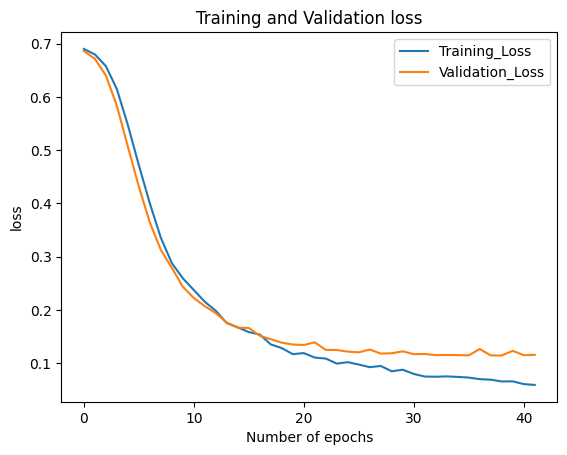

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

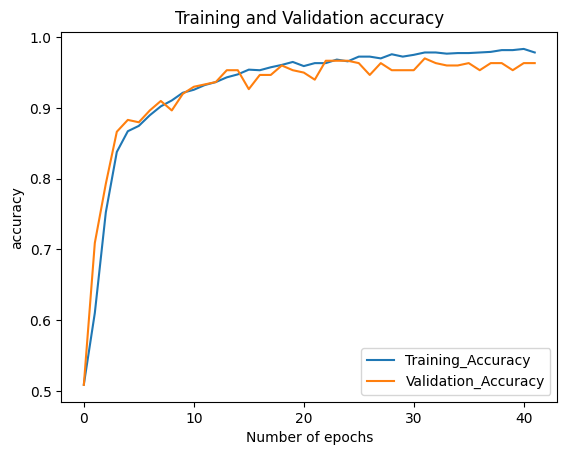

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
#Prediction of test data
pred = model.predict(testing_padded)
pred = pred.round()
pred

10/10 [==============================] - 0s 3ms/step


array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],

In [ ]:
from sklearn.metrics import classification_report
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(classification_report(test_labels, pred))

10/10 [==============================] - 0s 4ms/step - loss: 0.1156 - accuracy: 0.9632
Dense architecture loss and accuracy: [0.11563439667224884, 0.9632107019424438] 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       147
           1       0.98      0.95      0.96       152

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

